In [ ]:
!pip install transformers==4.30.2 peft==0.4.0 torch==2.0.1 torchvision==0.15.2 ftfy regex tqdm matplotlib
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.

In [ ]:
import os
import torch
import clip
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from transformers import ViTFeatureExtractor, ViTForImageClassification
from peft import LoraConfig, get_peft_model, PeftModel

from google.colab import drive, files

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [ ]:
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/vit_lora_project'
os.makedirs(save_path, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_models():
    """Load pre-trained ViT and CLIP models"""
    # Load pre-trained ViT model
    model_name = "google/vit-base-patch16-224"
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    vit_model = ViTForImageClassification.from_pretrained(model_name)

    # Load CLIP model
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

    return vit_model, feature_extractor, clip_model, clip_preprocess

# Load the models
vit_model, feature_extractor, clip_model, clip_preprocess = load_models()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 64.3MiB/s]


In [ ]:
def configure_lora(vit_model, num_classes=None):
    """Apply LoRA configuration to the ViT model"""
    # Configure LoRA
    lora_config = LoraConfig(
        r=4,  # rank
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
    )

    # Apply LoRA to the ViT model
    vit_model_lora = get_peft_model(vit_model, lora_config)

    # Modify classifier
    if num_classes is not None:
        vit_model_lora.classifier = torch.nn.Linear(
            vit_model_lora.classifier.in_features,
            num_classes
        ).to(device)

    print(f"Trainable parameters: {vit_model_lora.print_trainable_parameters()}")

    return vit_model_lora

# Configure LoRA for the ViT model
vit_model_lora = configure_lora(vit_model)


trainable params: 147,456 || all params: 86,715,112 || trainable%: 0.17004648509247153
Trainable parameters: None


In [ ]:
def prepare_datasets(dataset_path, batch_size=16):
    """
    Prepare training and validation datasets from a folder structure
    where each subfolder is a class
    """
    # Define transforms for training
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Define transforms for val
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load the full dataset
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

    # class name mapping
    idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
    class_to_idx = full_dataset.class_to_idx

    print(f"Dataset loaded with {len(full_dataset)} images across {len(class_to_idx)} classes")
    for class_name, idx in class_to_idx.items():
        class_count = sum(1 for _, label in full_dataset.samples if label == idx)
        print(f"  - {class_name}: {class_count} images")

    # Split
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Apply validation transform
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, class_to_idx, idx_to_class


In [ ]:
def fine_tune_with_lora(vit_model_lora, train_loader, val_loader,
                        class_to_idx, idx_to_class, num_epochs=5, learning_rate=5e-5):
    """
    Fine-tune the ViT model with LoRA on an art styles dataset
    """
    #fine-tuning
    vit_model_lora.to(device)

    # optimizer and loss function
    optimizer = torch.optim.AdamW(vit_model_lora.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Training loop
    best_val_acc = 0.0

    for epoch in range(num_epochs):

        vit_model_lora.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = vit_model_lora(images).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            # Update
            train_progress.set_postfix({
                'loss': train_loss / train_total,
                'acc': 100. * train_correct / train_total
            })

        # Val phase
        vit_model_lora.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = vit_model_lora(images).logits
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                # Update
                val_progress.set_postfix({
                    'loss': val_loss / val_total,
                    'acc': 100. * val_correct / val_total
                })

        # Calculate epoch statistics
        train_loss = train_loss / train_total
        train_acc = 100. * train_correct / train_total
        val_loss = val_loss / val_total
        val_acc = 100. * val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Update learning rate
        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            save_dir = os.path.join(save_path, "vit_lora_finetuned")
            os.makedirs(save_dir, exist_ok=True)
            vit_model_lora.save_pretrained(save_dir)

            # Save class mapping
            with open(os.path.join(save_dir, "class_mapping.json"), "w") as f:
                json.dump({"idx_to_class": idx_to_class, "class_to_idx": class_to_idx}, f)

            print(f"New best model saved with validation accuracy: {val_acc:.2f}%")

    print(f"Fine-tuning completed. Best validation accuracy: {best_val_acc:.2f}%")
    return vit_model_lora


In [ ]:
def classify_image_zero_shot(image_path, categories, clip_model, clip_preprocess):
    """
    Classify an image using zero-shot learning with CLIP

    Args:
        image_path: Path to the image file
        categories: List of text categories for classification
        clip_model: Pre-trained CLIP model
        clip_preprocess: CLIP preprocessing function

    Returns:
        Dictionary of categories and their similarity scores
    """
    # Load image
    image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Encode image
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Prepare text prompts
    text_prompts = [f"a photo of {category} art style" for category in categories]
    text = clip.tokenize(text_prompts).to(device)

    # Encode text
    with torch.no_grad():
        text_features = clip_model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    results = {}
    for i, category in enumerate(categories):
        results[category] = similarity[0][i].item()

    return results


In [ ]:
def classify_image_hybrid(image_path, categories, vit_model_lora, feature_extractor,
                         clip_model, clip_preprocess, class_mapping=None):
    """
    Classify an image using both fine-tuned ViT-LoRA and zero-shot CLIP

    Args:
        image_path: Path to the image file
        categories: List of text categories for classification
        vit_model_lora: Fine-tuned ViT model with LoRA
        feature_extractor: ViT feature extractor
        clip_model: Pre-trained CLIP model
        clip_preprocess: CLIP preprocessing function
        class_mapping: Dictionary mapping class indices to class names

    Returns:
        Dictionary of categories and their combined scores
    """
    # Get CLIP zero-shot results
    clip_results = classify_image_zero_shot(image_path, categories, clip_model, clip_preprocess)

    # If we have a fine-tuned model and class mapping
    if vit_model_lora is not None and class_mapping is not None:
        # Load and preprocess the image for ViT
        image = Image.open(image_path)
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)

        # Get ViT predictions
        vit_model_lora.eval()
        with torch.no_grad():
            outputs = vit_model_lora(**inputs).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

        # Convert ViT predictions to dictionary
        vit_results = {}
        idx_to_class = class_mapping["idx_to_class"]

        for idx, prob in enumerate(probabilities):
            class_name = idx_to_class[str(idx)]
            if class_name in categories:
                vit_results[class_name] = prob.item()

        # For categories not in the fine-tuned model, use only CLIP scores
        for category in categories:
            if category not in vit_results:
                vit_results[category] = 0.0

        # Combine results (weighted avg: 70% ViT, 30% CLIP)
        combined_results = {}
        for category in categories:
            vit_score = vit_results.get(category, 0.0)
            clip_score = clip_results.get(category, 0.0)
            combined_results[category] = 0.7 * vit_score + 0.3 * clip_score

        return combined_results

    # If no fine-tuned model or class mapping, return CLIP results
    return clip_results


In [ ]:
def upload_and_classify(vit_model_lora=None, class_mapping=None):
    """
    Upload an image and classify it with user-defined categories

    Args:
        vit_model_lora: Fine-tuned ViT model with LoRA (optional)
        class_mapping: Dictionary mapping class indices to class names (optional)
    """
    print("Upload an image for classification:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    image_path = list(uploaded.keys())[0]

    # Get user categories
    if class_mapping is not None:
        available_classes = list(class_mapping["idx_to_class"].values())
        print(f"Available classes: {', '.join(available_classes)}")
        print("You can also specify custom categories not in the trained model.")

    categories_input = input("Enter categories separated by commas (e.g., 'renaissance,impressionist,cubism'): ")
    categories = [cat.strip() for cat in categories_input.split(',')]

    if not categories:
        print("No categories provided.")
        return

    # Classify the image
    if vit_model_lora is not None and class_mapping is not None:
        # Use hybrid classification
        results = classify_image_hybrid(
            image_path, categories, vit_model_lora, feature_extractor,
            clip_model, clip_preprocess, class_mapping
        )
        method = "Hybrid (ViT-LoRA + CLIP)"
    else:
        # Use zero-shot classification
        results = classify_image_zero_shot(image_path, categories, clip_model, clip_preprocess)
        method = "Zero-shot (CLIP only)"

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    categories = [item[0] for item in sorted_results]
    scores = [item[1] for item in sorted_results]
    y_pos = np.arange(len(categories))

    plt.barh(y_pos, scores)
    plt.yticks(y_pos, categories)
    plt.xlabel("Confidence Score")
    plt.title(f"Classification Results ({method})")

    plt.tight_layout()
    plt.show()

    print(f"\nClassification Results ({method}):")
    for category, score in sorted_results:
        print(f"{category}: {score:.4f}")


In [ ]:
def load_fine_tuned_model():
    """Load a previously fine-tuned ViT-LoRA model"""
    model_path = os.path.join(save_path, "vit_lora_finetuned")

    if not os.path.exists(model_path):
        print("No fine-tuned model found.")
        return None, None

    # Load the base ViT model
    model_name = "google/vit-base-patch16-224"
    vit_model = ViTForImageClassification.from_pretrained(model_name)

    # Load the LoRA weights
    vit_model_lora = PeftModel.from_pretrained(vit_model, model_path)

    # Load class mapping
    class_mapping_path = os.path.join(model_path, "class_mapping.json")
    if os.path.exists(class_mapping_path):
        with open(class_mapping_path, "r") as f:
            class_mapping = json.load(f)
        print(f"Loaded fine-tuned model with {len(class_mapping['idx_to_class'])} classes")
        return vit_model_lora, class_mapping
    else:
        print("Class mapping not found.")
        return vit_model_lora, None


ViT + LoRA Zero-Shot Image Classification for Art Styles
1. Fine-tune model on art style dataset
2. Load fine-tuned model and classify images
3. Use zero-shot classification (no fine-tuning)

Enter your choice (1/2/3): 1
Enter path to art styles dataset: /content/drive/MyDrive/art_styles_dataset
Dataset loaded with 800 images across 8 classes
  - Art_Nouveasu: 100 images
  - Baroque: 100 images
  - Primitivism: 100 images
  - Realism: 100 images
  - Renaissance: 100 images
  - Rococo: 100 images
  - Romanticism: 100 images
  - Symbolism: 100 images
trainable params: 153,608 || all params: 86,721,264 || trainable%: 0.17712841454893924
Trainable parameters: None
Enter number of epochs (default: 5): 4


Epoch 1/4 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/4 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/4 - Train Loss: 9.9824, Train Acc: 0.00% - Val Loss: 9.6619, Val Acc: 0.00%


Epoch 2/4 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/4 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/4 - Train Loss: 9.6290, Train Acc: 0.00% - Val Loss: 9.1457, Val Acc: 0.00%


Epoch 3/4 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/4 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/4 - Train Loss: 9.0787, Train Acc: 0.00% - Val Loss: 8.6393, Val Acc: 0.00%


Epoch 4/4 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/4 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/4 - Train Loss: 8.7058, Train Acc: 0.00% - Val Loss: 8.4604, Val Acc: 0.00%
Fine-tuning completed. Best validation accuracy: 0.00%
No fine-tuned model found.
Upload an image for classification:


Saving 185328.jpg to 185328.jpg
Enter categories separated by commas (e.g., 'renaissance,impressionist,cubism'): cubism, expressionism


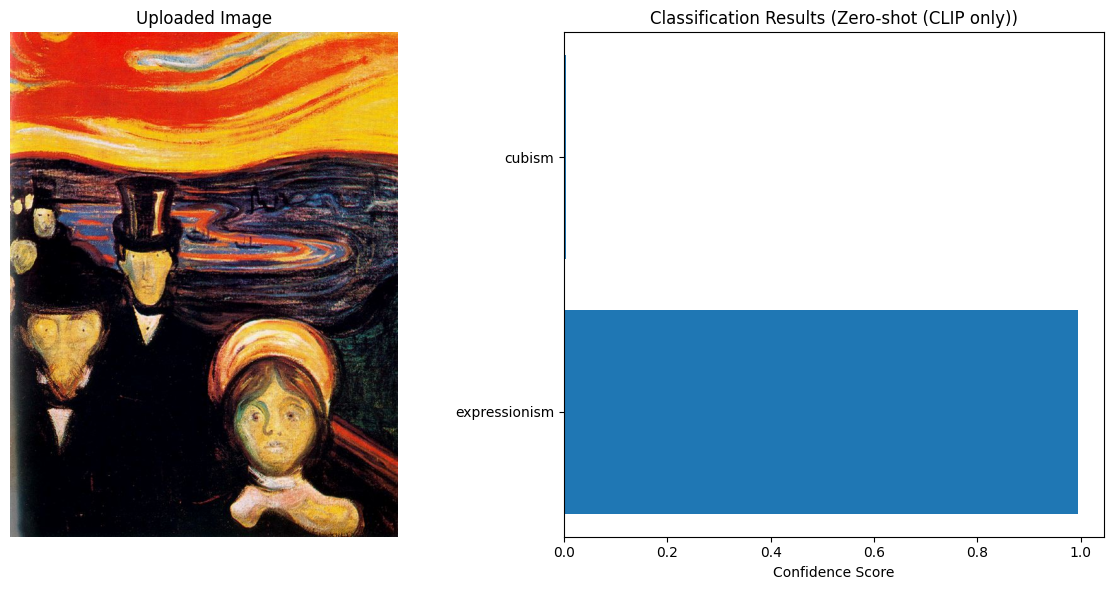


Classification Results (Zero-shot (CLIP only)):
expressionism: 0.9951
cubism: 0.0048
Classify another image? (y/n): n


In [ ]:
def main():
    """Main execution flow with user options"""
    print("ViT + LoRA Zero-Shot Image Classification for Art Styles")
    print("=" * 60)
    print("1. Fine-tune model on art style dataset")
    print("2. Load fine-tuned model and classify images")
    print("3. Use zero-shot classification (no fine-tuning)")

    choice = input("\nEnter your choice (1/2/3): ")

    if choice == '1':
        # Fine-tune model
        dataset_path = input("Enter path to art styles dataset: ")
        if not os.path.exists(dataset_path):
            print(f"Dataset path {dataset_path} does not exist.")
            return

        train_loader, val_loader, class_to_idx, idx_to_class = prepare_datasets(dataset_path)

        # Configure LoRA with correct number of classes
        num_classes = len(class_to_idx)
        vit_model_lora = configure_lora(vit_model, num_classes)

        # Fine-tune the model
        epochs = int(input("Enter number of epochs (default: 5): ") or "5")
        fine_tune_with_lora(vit_model_lora, train_loader, val_loader,
                           class_to_idx, idx_to_class, num_epochs=epochs)

        vit_model_lora, class_mapping = load_fine_tuned_model()

        # Classify images
        while True:
            upload_and_classify(vit_model_lora, class_mapping)
            if input("Classify another image? (y/n): ").lower() != 'y':
                break

    elif choice == '2':
        # Load fine-tuned model
        vit_model_lora, class_mapping = load_fine_tuned_model()

        if vit_model_lora is None:
            print("No fine-tuned model available. Please fine-tune a model first.")
            return

        # Classify images
        while True:
            upload_and_classify(vit_model_lora, class_mapping)
            if input("Classify another image? (y/n): ").lower() != 'y':
                break

    elif choice == '3':
        # Use zero-shot classification
        print("Using zero-shot classification with CLIP (no fine-tuning)")

        # Classify images
        while True:
            upload_and_classify()
            if input("Classify another image? (y/n): ").lower() != 'y':
                break

    else:
        print("Invalid choice.")

if __name__ == "__main__":
    main()


In [ ]:
def visualize_dataset_samples(dataset_path, num_samples=5):
    """Visualize random samples from each class in the dataset"""
    import random

    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_path)
                    if os.path.isdir(os.path.join(dataset_path, f))]

    # Create a figure
    num_classes = len(class_folders)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 3*num_classes))

    # For each class, show random samples
    for i, class_name in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Select random
        selected_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert('RGB')

            if num_classes > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]

            ax.imshow(img)
            ax.set_title(class_name if j == 0 else "")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def analyze_model_performance(vit_model_lora, val_loader, class_mapping):
    """Analyze model performance on validation set with confusion matrix"""
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    # Set model to evaluation mode
    vit_model_lora.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = vit_model_lora(images).logits
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)


    idx_to_class = class_mapping["idx_to_class"]
    class_names = [idx_to_class[str(i)] for i in range(len(idx_to_class))]


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
vit_model_lora.save_pretrained('/content/drive/MyDrive/vit_lora_project')